## Travelling Salesman Problem

The Travelling Salesman Problem, TSP, describes a scenario where a salesman wishes to visit a list of cities, taking the shortest possible route, before returning home to the start point. While it may appear simple, this problem not only has no known polynomial time solution, but there is also no time-efficient way to prove that a given solution is in fact optimal.

The difficulty of this problem increases quickly with the number of nodes in the network we are considering.

| Total Number of Vertices | Number of Possible Routes|
|:------------------------:|:------------------------:|
|4| 3|
|5|12|
|6|60|
|10|1811440|
|12|19,958,400|
|20|6.1x10^16|

In this notebook, we will build some tools to help us create and visualise graphs, implement a Nearest Neighbour approach to solving the TSP, and then explore a Genetic Algorihtm method for producing better results.

## Graph Construction - Defining The Problem

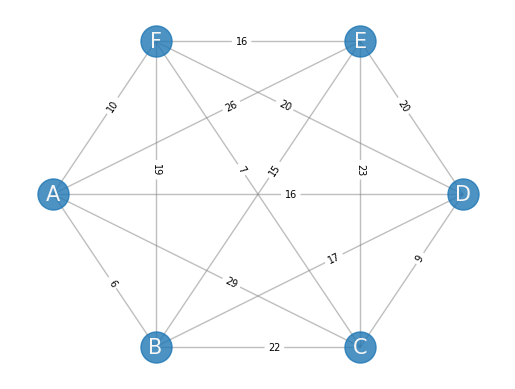

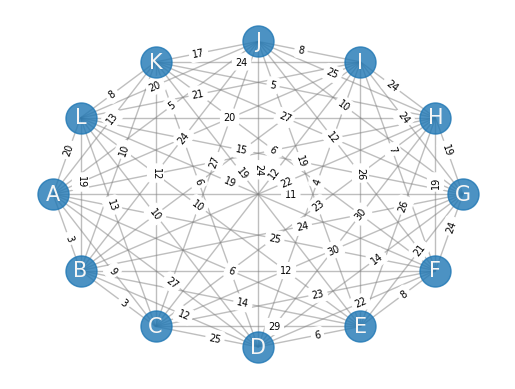

Temps CPU = 36.109375
Meilleur circuit : ['A', 'F', 'C', 'E', 'C', 'D', 'H', 'I', 'E', 'C', 'H', 'D', 'A'], Distance totale : 109.0


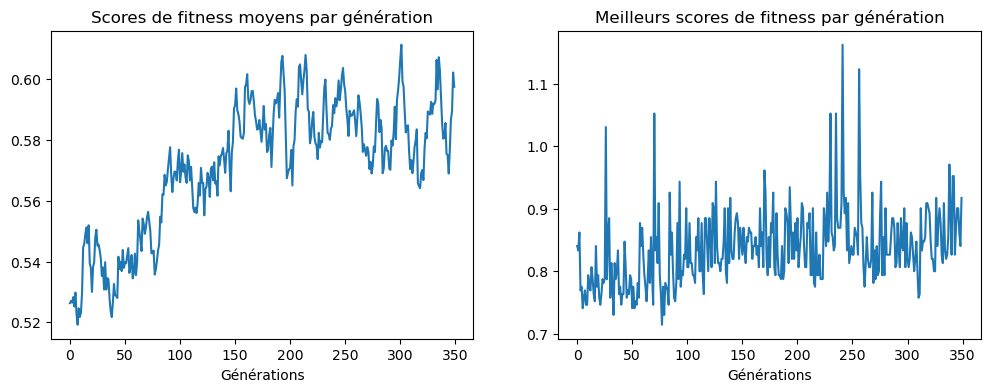

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time



# given a distance matrix and a list of node labels, construct a visualisation of the graph described
def draw_graph(node_labels, dist_matrix):

    # take subset of the node labels that are relevant for this graph
    node_labels = {i: node_labels[i] for i in range(dist_matrix.shape[0])}
    
    # convert to integers for better readability
    dist_matrix = np.array(dist_matrix, dtype=int)

    # construct graph from matrix
    G = nx.from_numpy_array(dist_matrix)

    # define layout - nodes around perimeter of a circle    
    pos=nx.shell_layout(G)
    
    # draw vertices
    options = {"node_size": 500, "alpha": 0.8, "node_color": "tab:blue"}
    nx.draw_networkx_nodes(G, pos, **options)
    
    options = {"font_size": 15, "font_color": "whitesmoke"}
    nx.draw_networkx_labels(G, pos, node_labels, **options)
    
    # draw edges
    options = {"width": 1, "edge_color": "tab:gray", "alpha":0.5}
    nx.draw_networkx_edges(G, pos, **options)
    
    options = {"font_size": 7, "font_color": "black", "label_pos": 0.42}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'), **options)

    # display graph
    plt.axis('off')
    plt.savefig("Graph.png") # save as png
    plt.show()

# build a distance matrix given the number of nodes
# we populate this matrix with random values
# ensure it is symmetric, and with zeros on the leading diagonal
def generate_graph(num_nodes):

    # matrix of zeros
    m = np.zeros((num_nodes, num_nodes))
    
    # populate with random values
    for i in range(num_nodes):
        for j in range(i):
            rand = random.randint(2, 30)
            m[i][j] = rand
            m[j][i] = rand

    return m

# support for up to 15 nodes
# adding more than 10 may cause some edge labels to be unreadable
node_labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O"}
m = generate_graph(6)

draw_graph(node_labels, m)
# PSO Particle Class
class Particle:
    def __init__(self, num_cities):
        self.position = np.random.permutation(num_cities)  # Position = solution au TSP (chemin)
        self.velocity = np.zeros(num_cities)  # Vitesse initiale
        self.best_position = np.copy(self.position)
        self.best_fitness = float('inf')

# Fonction fitness, évaluant la qualité d'une solution (chromosome ou particule)
def fitness(chromosome, m):
    score = 0
    for i, gene in enumerate(chromosome):
        if i == 0:
            score += m[0, gene]  # Arc du point de départ à la première ville
        else:
            score += m[gene, chromosome[i-1]]  # Arc entre les villes successives
    score += m[0, chromosome[-1]]  # Retour à la ville de départ
    return 100 / score  # Inverse de la distance pour que les scores plus élevés soient meilleurs

# Mise à jour des particules PSO
def update_particles(particles, global_best_position, m, w=0.5, c1=1.5, c2=1.5):
    for particle in particles:
        inertia = w * particle.velocity
        cognitive = c1 * np.random.rand() * (particle.best_position - particle.position)
        social = c2 * np.random.rand() * (global_best_position - particle.position)
        particle.velocity = inertia + cognitive + social
        particle.position = (particle.position + particle.velocity).astype(int)
        particle.position = np.mod(particle.position, len(particle.position))  # Garder les indices dans les bornes

        # Mise à jour de la fitness de la particule
        current_fitness = fitness(particle.position, m)
        if current_fitness < particle.best_fitness:
            particle.best_fitness = current_fitness
            particle.best_position = np.copy(particle.position)

# Initialisation de la population PSO
def initialize_pso_population(num_particles, num_cities):
    particles = [Particle(num_cities) for _ in range(num_particles)]
    global_best_position = np.copy(particles[0].position)
    global_best_fitness = fitness(global_best_position, m)
    return particles, global_best_position, global_best_fitness

# Crossover par ordre corrigé
def order_crossover(x1, x2):
    # Sélection de valeurs communes à réarranger
    values = np.random.choice(x1, size=min(len(x1), 3), replace=False)  # Choisir 3 éléments maximum

    # Obtenir les indices de ces valeurs dans chaque parent
    x1_index = [i for i in range(len(x1)) if x1[i] in values]
    x2_index = [i for i in range(len(x2)) if x2[i] in values]

    if len(x1_index) == len(x2_index) == len(values):
        # Réarranger les éléments sélectionnés
        temp = [x1[i] for i in x1_index]
        for i, idx in enumerate(x1_index):
            x1[idx] = x2[x2_index[i]]
        for i, idx in enumerate(x2_index):
            x2[idx] = temp[i]
    return x1, x2


# Mutation par permutation
def mutate1(x):
    index = np.random.choice(range(len(x)), size=2, replace=False)
    temp = x[index[0]]
    x[index[0]] = x[index[1]]
    x[index[1]] = temp
    return x

# Sélection par roulette
def roulette_wheel_selection(pop_size, fitness_scores):
    return random.choices(range(pop_size), weights=fitness_scores, k=2)

# Générer la population initiale pour GA
def generate_initial_population(num_nodes, pop_size):
    nodes = [i for i in range(1, num_nodes)]  # Liste des villes (sans le point de départ)
    population = []
    for i in range(pop_size):
        random.shuffle(nodes)
        population.append(nodes.copy())
    return population

# Boucle principale pour GA + PSO
def hybrid_ga_pso(population, iterations, num_particles, selection, crossover, crossover_threshold, mutation, mutation_threshold, elitism):
    pop_size = len(population)
    mean_fitness_scores = []
    best_fitness_scores = []

    # Initialisation de la population PSO
    particles, global_best_position, global_best_fitness = initialize_pso_population(num_particles, len(population[0]))

    # Évaluation initiale de la population GA
    fitness_scores = [fitness(i, m) for i in population]
    order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
    population = [population[i] for i in order]
    fitness_scores = sorted(fitness_scores, reverse=True)

    for iter in range(iterations):
        new_pop = copy.deepcopy(population)
        replaced = elitism

        # Mise à jour des particules PSO
        update_particles(particles, global_best_position, m)
        for particle in particles:
            particle_fitness = fitness(particle.position, m)
            if particle_fitness < global_best_fitness:
                global_best_fitness = particle_fitness
                global_best_position = np.copy(particle.position)

        # Construction de la nouvelle population GA
        while replaced < pop_size:
            index = selection(pop_size, fitness_scores)

            # Crossover
            if random.random() < crossover_threshold:
                child1, child2 = crossover(population[index[0]].copy(), population[index[1]].copy())
            else:
                child1, child2 = population[index[0]].copy(), population[index[1]].copy()

            # Mutation
            if random.random() < mutation_threshold:
                child1 = mutation(child1)
            if random.random() < mutation_threshold:
                child2 = mutation(child2)

            # Remplacement
            new_pop[replaced] = child1
            replaced += 1
            if replaced < pop_size:
                new_pop[replaced] = child2
                replaced += 1

        # Mise à jour de la population GA
        population = new_pop
        fitness_scores = [fitness(i, m) for i in population]

        # Tri de la population par score de fitness
        order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
        population = [population[i] for i in order]
        fitness_scores = sorted(fitness_scores, reverse=True)

        # Insertion de la meilleure solution PSO dans la population GA
        population[0] = global_best_position.copy()

        # Calcul des scores moyens et meilleurs
        mean_fitness_scores.append(np.mean(fitness_scores))
        best_fitness_scores.append(fitness_scores[0])

    return mean_fitness_scores, best_fitness_scores, population[0].copy()

# Initialisation des paramètres
iterations = 350
pop_size = 250
num_nodes = 12  # Nombre de villes
num_particles = 30  # Nombre de particules PSO

# Génération du graphe
m = generate_graph(num_nodes)
draw_graph(node_labels, m)

# Génération de la population initiale
population = generate_initial_population(num_nodes=num_nodes, pop_size=pop_size)

# Lancer l'algorithme hybride GA + PSO après correction du crossover
mean_fitness, best_fitness, tour = hybrid_ga_pso(
    population=population,
    iterations=iterations,
    num_particles=num_particles,
    selection=roulette_wheel_selection,
    crossover=order_crossover,  # Crossover corrigé
    crossover_threshold=0.7,
    mutation=mutate1,
    mutation_threshold=0.25,
    elitism=1
)

end_time = time.process_time()
cpu_time = end_time - start_time

print('Temps CPU =', cpu_time)

# Affichage des résultats après GA + PSO
tour = ["A"] + [node_labels[i] for i in tour] + ["A"]
print(f"Meilleur circuit : {tour}, Distance totale : {np.round(100 / best_fitness[-1])}")

# Tracer les résultats
x = range(iterations)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(x, mean_fitness)
ax[0].set_title("Scores de fitness moyens par génération")
ax[0].set_xlabel("Générations")
ax[1].plot(x, best_fitness)
ax[1].set_title("Meilleurs scores de fitness par génération")
ax[1].set_xlabel("Générations")
plt.show()
